# Hydrodynamics Systems with a General EOS

This notebook explores the eigensystem of the Euler equations augmented with an additional thermodynamic variable to describe a general equation of state in the reconstruction of interface states

In [1]:
from sympy import init_session
init_session()

IPython console for SymPy 1.0 (Python 2.7.12-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


In [2]:
from sympy.abc import rho, tau, alpha
rho, tau, c, h = symbols("rho tau c h", real=True, positive=True)
alpha, u = symbols("alpha u", real=True)

The two routines below simplify the analysis of the eigensystem by simultaneously finding the set of orthonormal left and right eigenvectors of a matrix from the primitive form of the hydro equations

In [3]:
plus = u + c
zero = u
minus = u - c

class Eigenvector(object):
    def __init__(self, name, ev, r, l=None):
        self.name = name
        if name == "minus":
            self.d = 0
        elif name == "zero":
            self.d = 1
        elif name == "plus":
            self.d = 2
        else:
            self.d = None

        self.ev = ev
        self.l = l
        self.r = r

    def __lt__(self, other):
        return self.d < other.d

    def __str__(self):
        return "{} wave, r = {}, l = {}".format(self.eigenvalue, self.r, self.l)

def eigensystem(A, suba=None, subb=None):
    # get the left and right eigenvectors that diagonalize the system.
    # it is best to use sympy diagonalize() for this purpose than getting
    # the left and right eigenvectors independently.

    e = []

    R, D = A.diagonalize()

    # the columns of R are the right eigenvectors and the diagonal
    # element of D is the corresponding eigenvalues

    for n in range(A.shape[0]):
        r = R.col(n)
        ev = D[n,n]
                    
        #print("here", r, ev)
        if suba is not None and subb is not None:
            ev = ev.subs(suba, subb)
            
        # which eigenvalue are we?
        if simplify(ev - minus) == 0:
            name = "minus"
        elif simplify(ev - plus) == 0:
            name = "plus"
        elif simplify(ev - zero) == 0:
            name = "zero"
        else:
            return None
                                                                                                            
        # normalize the right eigenvector
        v = r[0]
        if v != 0:
            r = r/v

        if suba is not None and subb is not None:
            r = simplify(r.subs(suba, subb))
            
        e.append(Eigenvector(name=name, ev=ev, r=r))

    # now sort the system from smallest (u-c) to largest (u+c)
    e.sort()

    # now let's construct the R with this sorting
    for n in range(A.shape[0]):
        R[:,n] = e[n].r

    # the left eigenvector matrix, L, is just the inverse
    L = R**-1

    for n in range(A.shape[0]):
        e[n].l = L.row(n)

    return e

# Euler Equations with $(\rho e)$

The Euler equations in primitive variable form, $q = (\rho, u, p, (\rho e))^\intercal$ appear as:
\begin{align}
\frac{\partial \rho}{\partial t} &= -u \frac{\partial \rho}{\partial x} - \rho \frac{\partial u}{\partial x} \\
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{1}{\rho} \frac{\partial p}{\partial x} \\
\frac{\partial p}{\partial t} &= -u \frac{\partial p}{\partial x} - \rho c^2 \frac{\partial u}{\partial x} \\
\frac{\partial (\rho e)}{\partial t} &= -u \frac{\partial (\rho e)}{\partial x} - \rho h \frac{\partial u}{\partial x} 
\end{align}

In vector form, we have:
$$q_t + A(q) q_x = 0$$

with the matrix $A(q)$:


$$A(q) = \left ( \begin{array}{cccc} u  & \rho     & 0    & 0\\                          
                                  0  &  u       & 1/\rho  & 0\\                     
                                  0  & \rho c^2 & u       & 0\\
                                  0  & \rho h & 0       & u\end{array} \right )  
$$

The sound speed is related to the adiabatic index, $\Gamma_1$, as $c^2 = \Gamma_1 p /\rho$.

We can represent this matrix symbolically in SymPy and explore its eigensystem.

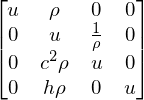

In [4]:
A = Matrix([[u, rho, 0, 0], [0, u, rho**-1, 0], [0, c**2 * rho, u, 0], [0, rho*h, 0, u]])
A

The eigenvalues are the speeds at which information propagates with.  SymPy returns them as a
dictionary, giving the multiplicity for each eigenvalue.

In [5]:
A.eigenvals()

We see that there are 2 eigenvalues $u$ -- the addition of $(\rho e)$ to the system adds this degeneracy.

## Eigenvectors

The right eigenvectors are defined for a given eigenvalue, $\lambda$, as:
$$A r = \lambda r$$
and the left eigenvectors satisfy:
$$l A = \lambda l$$

Note that the left and right eigenvectors are orthogonal to those corresponding to a different eigenvalue, and usually normalized so:
$$l^i \cdot r^j = \delta_{ij}$$

In [6]:
# we use the helper rountines above to find the orthogonal left and right eigenvectors
eigen = eigensystem(A)

minus


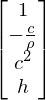

zero


zero


plus


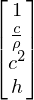

In [7]:
# printing them out for inspection
from sympy.printing.mathml import mathml
for e in eigen:
    print(e.name)
    display(e.r, e.l)

## $\beta$'s

The tracing projects the primitive variables into characteristic variables by defining
$$
\Delta q = \left ( \begin{array}{c} \Delta \rho \\ \Delta u \\ \Delta p \\ \Delta (\rho e) \end{array} \right )
$$
and then
$\beta^\nu = l^\nu \cdot \Delta q$

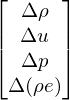

In [8]:
from sympy.abc import delta

dr = symbols(r"\Delta\rho")
du = symbols(r"\Delta{}u")
dp = symbols(r"\Delta{}p")
dre = symbols(r"\Delta(\rho{}e)")

dq = Matrix([[dr, du, dp, dre]]).transpose()
dq

minus


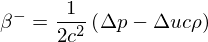

zero


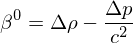

zero


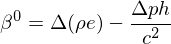

plus


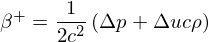

In [9]:
bm, bz, bp = symbols(r"\beta^- \beta^0 \beta^+")
betas = [bm, bz, bp]
for e in eigen:
    print e.name
    beta = e.l.dot(dq)
    display(Eq(betas[e.d], simplify(beta)))

-----

# Euler Equations with $(\gamma_e)$

We can define $\gamma_e = p/(\rho e) + 1$ and differentiate it to get:
$$
\frac{\partial \gamma_e}{\partial t} = -u \frac{\partial \gamma_e}{\partial x} + (\gamma_e - 1)(\gamma_e - \Gamma_1) \frac{\partial u}{\partial x}
$$
The original CG paper used $\tau = 1/\rho$ in place of density.  With this, the continuity equation becomes:
$$
\frac{\partial \tau}{\partial t} = -u\frac{\partial \tau}{\partial x}  + \tau \frac{\partial u}{\partial x}
$$

The Euler equations with this set of primitive variables, $q = (\tau, u, p, \gamma_e)^\intercal$ appear as:
\begin{align}
\frac{\partial \tau}{\partial t} &= -u\frac{\partial \tau}{\partial x}  + \tau \frac{\partial u}{\partial x} \\
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{1}{\rho} \frac{\partial p}{\partial x} \\
\frac{\partial p}{\partial t} &= -u \frac{\partial p}{\partial x} - \rho c^2 \frac{\partial u}{\partial x} \\
\frac{\partial \gamma_e}{\partial t} &= -u \frac{\partial \gamma_e}{\partial x} + (\gamma_e - 1)(\gamma_e - \Gamma_1) \frac{\partial u}{\partial x}
\end{align}

For convenience, we define
$$
\alpha = (\gamma_e - 1)(\gamma_e - \Gamma_1)
$$
and then in vector form, we have:
$$q_t + A(q) q_x = 0$$

with the matrix $A(q)$:


$$A(q) = \left ( \begin{array}{cccc} u  & -\tau     & 0    & 0\\                          
                                  0  &  u       & \tau  & 0\\                     
                                  0  & c^2/\tau & u       & 0\\
                                  0  & -\alpha & 0       & u\end{array} \right )  
$$

We can represent this matrix symbolically in SymPy and explore its eigensystem.

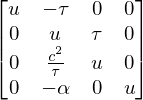

In [10]:
A = Matrix([[u, -tau, 0, 0], [0, u, tau, 0], [0, c**2/tau, u, 0], [0, -alpha, 0, u]])
A

The eigenvalues are the speeds at which information propagates with.  SymPy returns them as a
dictionary, giving the multiplicity for each eigenvalue.

In [11]:
A.eigenvals()

We see that there are 2 eigenvalues $u$ -- the addition of $\gamma_e$ to the system adds this degeneracy.

## Eigenvectors

In [12]:
# we use the helper rountines above to find the orthogonal left and right eigenvectors
eigen = eigensystem(A)

minus


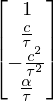

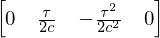

zero


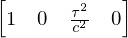

zero


plus


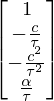

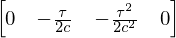

In [13]:
# printing them out for inspection
from sympy.printing.mathml import mathml
for e in eigen:
    print(e.name)
    display(e.r, e.l)

## $\beta$'s

The tracing projects the primitive variables into characteristic variables by defining
$$
\Delta q = \left ( \begin{array}{c} \Delta \rho \\ \Delta u \\ \Delta p \\ \Delta \gamma_e \end{array} \right )
$$
and then
$\beta^\nu = l^\nu \cdot \Delta q$

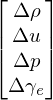

In [14]:
dge = symbols(r"\Delta\gamma_e")

dq = Matrix([[dr, du, dp, dge]]).transpose()
dq

minus


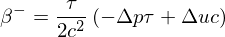

zero


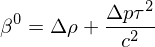

zero


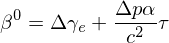

plus


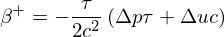

In [15]:
for e in eigen:
    print e.name
    beta = e.l.dot(dq)
    display(Eq(betas[e.d], simplify(beta)))

------

# Gray FLD Radiation Euler Equations with $(\rho e)$

Following Zhang et al. (2011), the equations of gray radiation hydrodynamics with primitive
variables $q = (\rho, u, p, (\rho e)_g, E_r)^\intercal$ are:
\begin{align}
\frac{\partial \rho}{\partial t} &= -u\frac{\partial \rho}{\partial x}  - \rho \frac{\partial u}{\partial x} \\
\frac{\partial u}{\partial t} &= -u \frac{\partial u}{\partial x} - \frac{1}{\rho} \frac{\partial p}{\partial x}
    - \frac{\lambda_f}{\rho} \frac{\partial E_r}{\partial x}\\
\frac{\partial p}{\partial t} &= -u \frac{\partial p}{\partial x} - \rho c_g^2 \frac{\partial u}{\partial x} \\
\frac{\partial (\rho e)_g}{\partial t} &= -u \frac{\partial (\rho e)_g}{\partial x} - \rho h \frac{\partial u}{\partial x} \\
\frac{\partial E_r}{\partial t} &= -\frac{3-f}{2} E_r \frac{\partial u}{\partial x} - \left ( \frac{3-f}{2} - \lambda_f\right ) u \frac{\partial E_r}{\partial x}
\end{align}
where $(\rho e)_g$ is the gas internal energy density, $h_g$ is the gas specific enthalpy, $c_g$ is the gas sound speed (obeying $c_g^2 = \Gamma_1 p /\rho$), $E_r$ is the radiation energy density, $f$ is the Eddington factor, and $\lambda_f$ is the flux limiter.

Following Zhang et al., we make the approximation that 
$$
\frac{3-f}{2} = \lambda_f + 1
$$
and then in vector form, we have:
$$q_t + A(q) q_x = 0$$

with the matrix $A(q)$:


$$A(q) = \left ( \begin{array}{ccccc} u  & \rho     & 0    & 0    & 0 \\                          
                                      0  &  u       & 1/\rho & 0   & \lambda_f/\rho\\                     
                                      0  & \rho c_g^2 & u       & 0 & 0 \\
                                      0  & \rho h_g   & 0       & u & 0 \\
                                      0  & (3-f)E_r/2   & 0       & 0 & u\end{array} \right )  
$$

We can represent this matrix symbolically in SymPy and explore its eigensystem.

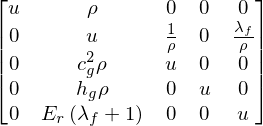

In [16]:
cg = symbols(r"c_g", real=True, positive=True)
hg = symbols(r"h_g", real=True, positive=True)
Er = symbols(r"E_r", real=True, positive=True)
lf = symbols(r"\lambda_f", real=True)
f = symbols("f", real=True, positive=True)

A = Matrix([[u, rho, 0, 0, 0], 
            [0, u, rho**-1, 0, lf/rho], 
            [0, rho*cg**2, u, 0, 0], 
            [0, rho*hg, 0, u, 0],
            [0, (lf+1)*Er, 0, 0, u]])
A

The eigenvalues are the speeds at which information propagates with.  SymPy returns them as a
dictionary, giving the multiplicity for each eigenvalue.

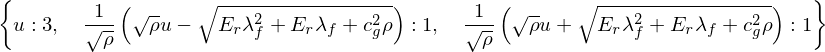

In [17]:
A.eigenvals()

We see that there are 3 eigenvalues $u$.  We identify the total sound speed (radiation + gas) as:
$$c^2 = c_g^2 + (\lambda_f + 1)\frac{\lambda_f E_r}{\rho}$$
We can simplify these by substituting in that relationship

In [18]:
q = c**2 - (lf +1)*lf*Er/rho
q
evs = A.eigenvals()
for e in evs.keys():
    display(powsimp(simplify(e.subs(cg**2, q))))

We see that these are the same form of the eigenvalues for the pure hydrodynamics system

## Eigenvectors

In [19]:
# we use the helper rountines above to find the orthogonal left and right eigenvectors
eigen = eigensystem(A, suba=cg, subb=sqrt(q))

minus


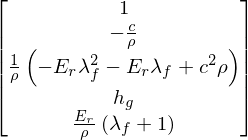

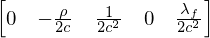

zero


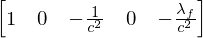

zero


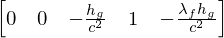

zero


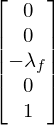

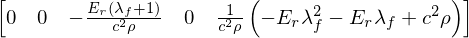

plus


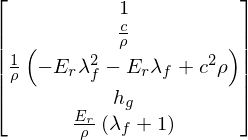

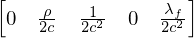

In [20]:
# printing them out for inspection
for e in eigen:
    print(e.name)
    display(e.r)
    display(simplify(e.l))

## $\beta$'s

The tracing projects the primitive variables into characteristic variables by defining
$$
\Delta q = \left ( \begin{array}{c} \Delta \rho \\ \Delta u \\ \Delta p \\ \Delta \gamma_e \end{array} \right )
$$
and then
$\beta^\nu = l^\nu \cdot \Delta q$

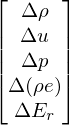

In [21]:
dEr = symbols(r"\Delta{}E_r")

dq = Matrix([[dr, du, dp, dre, dEr]]).transpose()
dq

minus


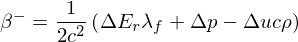

zero


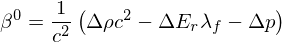

zero


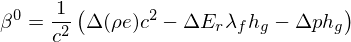

zero


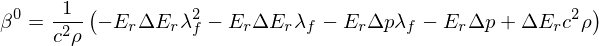

plus


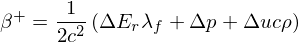

In [22]:
for e in eigen:
    print e.name
    beta = e.l.dot(dq)
    display(Eq(betas[e.d], simplify(beta)))

------

# 2-d system

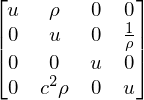

In [23]:
A = Matrix([[u, rho, 0, 0], [0, u, 0, rho**-1], [0,0, u, 0], [0, c**2 * rho, 0, u]])
A

In [24]:
A.eigenvals()

## Eigenvectors

In [25]:
# we use the helper rountines above to find the orthogonal left and right eigenvectors
eigen = eigensystem(A)

minus


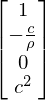

zero


zero


plus


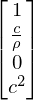

In [26]:
# printing them out for inspection
for e in eigen:
    print(e.name)
    display(e.r, e.l)